# Semantic Analysis of Titles
Semantic analysis and clustering of objects in the Wellcome Collection.

## Part 1: Data Extraction

The full metadata on all of the works in the Wellcome Collection is too large to fit into memory: the file is 13 GB. Thus, in order to process the data, we need to:
1. Download the full metadata on all the works on the collection
2. Extract the important aspects (title, subjects, author, languages)
3. Store those aspects in their own dataframe.


In [6]:
from pathlib import Path
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
from umap import UMAP
import gzip
import io
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import requests
import pyarrow  #for optional dependency

In [7]:
#https://stackoverflow.com/questions/51937381/increase-dpi-of-plt-show#
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [8]:
# Download the Names of the Works in the Wellcome Collection
# https://developers.wellcomecollection.org/docs/examples/extracting-features-from-text
import shutil

snapshot_url = "https://data.wellcomecollection.org/catalogue/v2/works.json.gz"

data_dir = Path("../../data").resolve()
data_dir.mkdir(exist_ok=True)

file_name = Path(snapshot_url).parts[-1]
zipped_path = data_dir / file_name
unzipped_path = zipped_path.with_suffix("")


if not unzipped_path.exists():
    if not zipped_path.exists():
        r = requests.get(snapshot_url, stream=True)
        download_progress_bar = tqdm(
            unit="B",
            total=int(r.headers["Content-Length"]),
            desc=f"downloading {file_name}",
        )
        with open(zipped_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
                    download_progress_bar.update(len(chunk))

    with gzip.open(zipped_path, "rb") as f_in:
        with open(unzipped_path, "wb") as f_out:
            unzip_progress_bar = tqdm(
                unit="B",
                total=zipped_path.stat().st_size,
                desc=f"unzipping {file_name}",
            )
            while True:
                chunk = f_in.read(1024)
                if not chunk:
                    break
                f_out.write(chunk)
                unzip_progress_bar.update(len(chunk))


In [11]:
# Opening the entire archive won't fit into memory: read 1 line at a time

with open(unzipped_path, "r", encoding="utf-8") as f:
    i = 0
    for line in f:
        record = json.loads(line)
        print(record['title'])
        i += 1
        if i >= 10:break

record['title']

Created from animals : the moral implications of Darwinism / James Rachels.
Reproductive biology of the great apes : comparative and biomedical perspectives / edited by Charles E. Graham.
Arminius, beschermer der Duytsche vryheid. Trevrspel
Science in India / Arun Kumar Biswas.
Adolf Gottstein (1857-1941) und die Hygiene in Berlin : eine Einführung zu seinem Aufsatz "Berlins hygienische Zustände vor 100 Jahren" / P. Schneck.
Dystonia musculorum deformans : with a discussion based on two cases / by Theodore Diller.
[Thomas Papillon correspondence].
Lettre sur les nouveaux bains medicinaux / par M. C*** docteur en medecine.
The jubilee book of the British Dental Association.
Titi Lvcretii Cari De rervm natvra libri sex. A Dionysio Lambino... locis innumerabilibus ex auctoritate quinque codicum manuscriptorum emendati, atque in antiquum ac natiuum statum ferè restituti & praeterea breuibus, et perquàm vtilibus commentariis illustrati.


'Titi Lvcretii Cari De rervm natvra libri sex. A Dionysio Lambino... locis innumerabilibus ex auctoritate quinque codicum manuscriptorum emendati, atque in antiquum ac natiuum statum ferè restituti & praeterea breuibus, et perquàm vtilibus commentariis illustrati.'

In [ ]:
record.keys()

dict_keys(['succeededBy', 'production', 'physicalDescription', 'subjects', 'items', 'designation', 'workType', 'identifiers', 'formerFrequency', 'alternativeTitles', 'id', 'languages', 'precededBy', 'partOf', 'genres', 'notes', 'holdings', 'title', 'type', 'contributors', 'images', 'availabilities', 'parts'])

In [ ]:
# Count total number of objects
total_object_count = 0
with open(unzipped_path, "r", encoding="utf-8") as f:
    for line in f:
        total_object_count += 1

print(f"Total Objects: {total_object_count}")

Total Objects: 1166599


In [ ]:
record['subjects']

[{'label': 'Biological Evolution - ethics',
  'concepts': [{'id': 'vjfb76xy',
    'identifiers': [{'identifierType': {'id': 'label-derived',
       'label': 'Identifier derived from the label of the referent',
       'type': 'IdentifierType'},
      'value': 'biological evolution',
      'type': 'Identifier'}],
    'label': 'Biological Evolution',
    'type': 'Concept'},
   {'id': 'zacdk477',
    'identifiers': [{'identifierType': {'id': 'label-derived',
       'label': 'Identifier derived from the label of the referent',
       'type': 'IdentifierType'},
      'value': 'ethics',
      'type': 'Identifier'}],
    'label': 'ethics',
    'type': 'Concept'}],
  'identifiers': [{'identifierType': {'id': 'nlm-mesh',
     'label': 'Medical Subject Headings (MeSH) identifier',
     'type': 'IdentifierType'},
    'value': 'D005075',
    'type': 'Identifier'}],
  'id': 's6msz274',
  'type': 'Subject'}]

In [ ]:
# Store only the important aspects

titles = []
subjects = []
languages = []

with open(unzipped_path, "r", encoding="utf-8") as f:
    for line in tqdm(f, desc="Processing records"):
        record = json.loads(line)

        # Extract title
        title = record.get("title", None)

        # Extract subject labels
        subj_list = record.get("subjects", [])
        subj_labels = [s.get('label') for s in subj_list if 'label' in s]

        # Extract languages (handle if they're dicts or strings)
        lang_list = record.get("languages", [])
        lang_labels = []
        for lang in lang_list:
            if isinstance(lang, dict) and 'label' in lang:
                lang_labels.append(lang['label'])
            elif isinstance(lang, str):
                lang_labels.append(lang)

        titles.append(title)
        subjects.append(subj_labels)
        languages.append(lang_labels)

# Create DataFrame
df = pd.DataFrame({
    'title': titles,
    'subjects': subjects,
    'languages': languages
})

Processing records: 0it [00:00, ?it/s]

In [ ]:
df['author'] = df['title'].apply(lambda row: row.rsplit('/', 1)[1] if len(row.rsplit('/', 1)) > 1 else None)
df['title_only'] = df['title'].apply(lambda row: row.rsplit('/', 1)[0] if len(row.rsplit('/', 1)) > 1 else row)

In [ ]:
df.to_feather("../../data/works_abridged_df.feather")

# Contributors and Topics

In [ ]:
df.head()

,title,subjects,languages,author,title_only
0,Created from animals : the moral implications ...,[Biological Evolution - ethics],[English],James Rachels.,Created from animals : the moral implications ...
1,Reproductive biology of the great apes : compa...,"[Apes - Reproduction, Mammals - Reproduction, ...",[English],edited by Charles E. Graham.,Reproductive biology of the great apes : compa...
2,"Arminius, beschermer der Duytsche vryheid. Tre...",[],[Dutch],None,"Arminius, beschermer der Duytsche vryheid. Tre..."
3,Science in India / Arun Kumar Biswas.,"[Science - history, India]",[English],Arun Kumar Biswas.,Science in India
4,Adolf Gottstein (1857-1941) und die Hygiene in...,"[19th century, Public Health - history, Berlin...",[German],P. Schneck.,Adolf Gottstein (1857-1941) und die Hygiene in...


In [ ]:
df.shape

(1166599, 5)

In [ ]:
subset_df = df.sample(100000)

In [ ]:
topics = subset_df['subjects'].explode().value_counts()
topics

subjects
Sanitation                                                          5562
Public Health                                                       5472
Disease Outbreaks                                                   5245
Water Supply                                                        5241
Great Britain                                                       1712
                                                                    ... 
Medicine - England - History - 17th century                            1
Technology - Societies, etc. - Periodicals                             1
Industrial arts - Societies, etc. - Periodicals                        1
Sadik, Nafis.                                                          1
India - History - British occupation, 1765-1947 - Historiography       1
Name: count, Length: 41356, dtype: int64

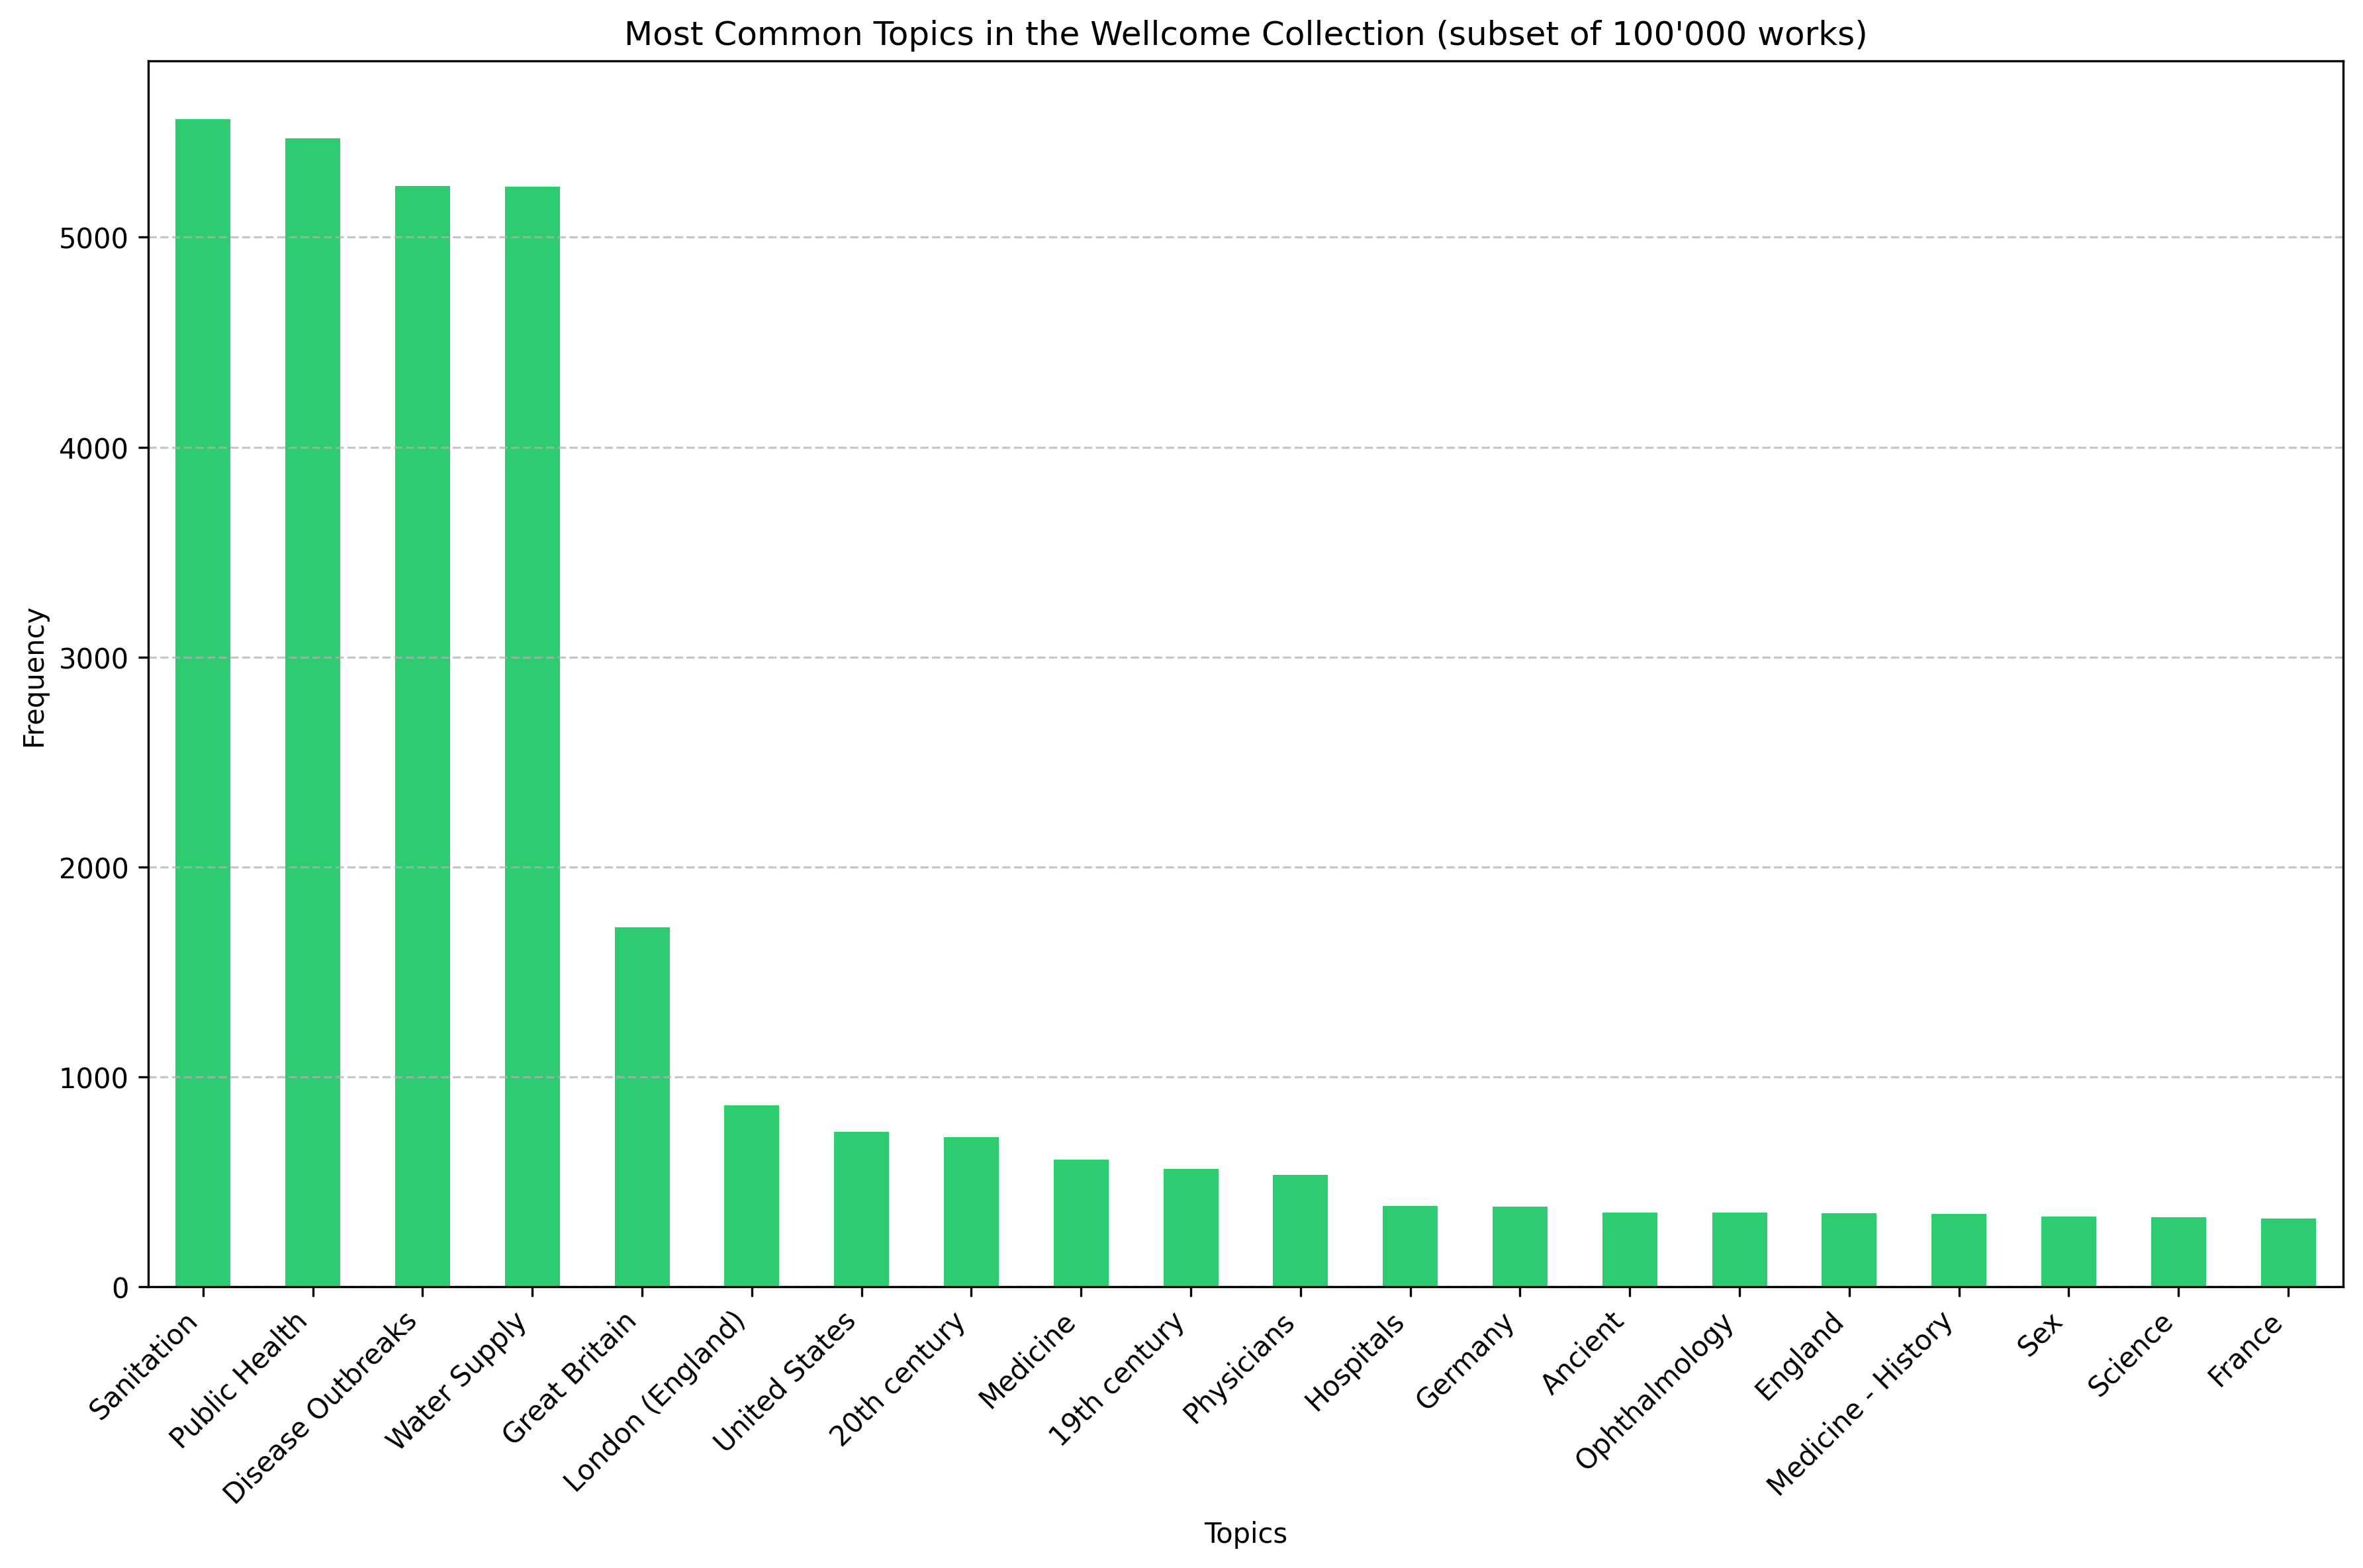

In [ ]:
# Only takig the topics that appear more than 10 times in the subset
top_topics = topics[:20]

# Plotting
plt.figure(figsize=(12, 8))
bars = top_topics.plot(kind='bar', color='#2ecc71')
plt.title("Most Common Topics in the Wellcome Collection (subset of 100'000 works)")
plt.xlabel('Topics')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


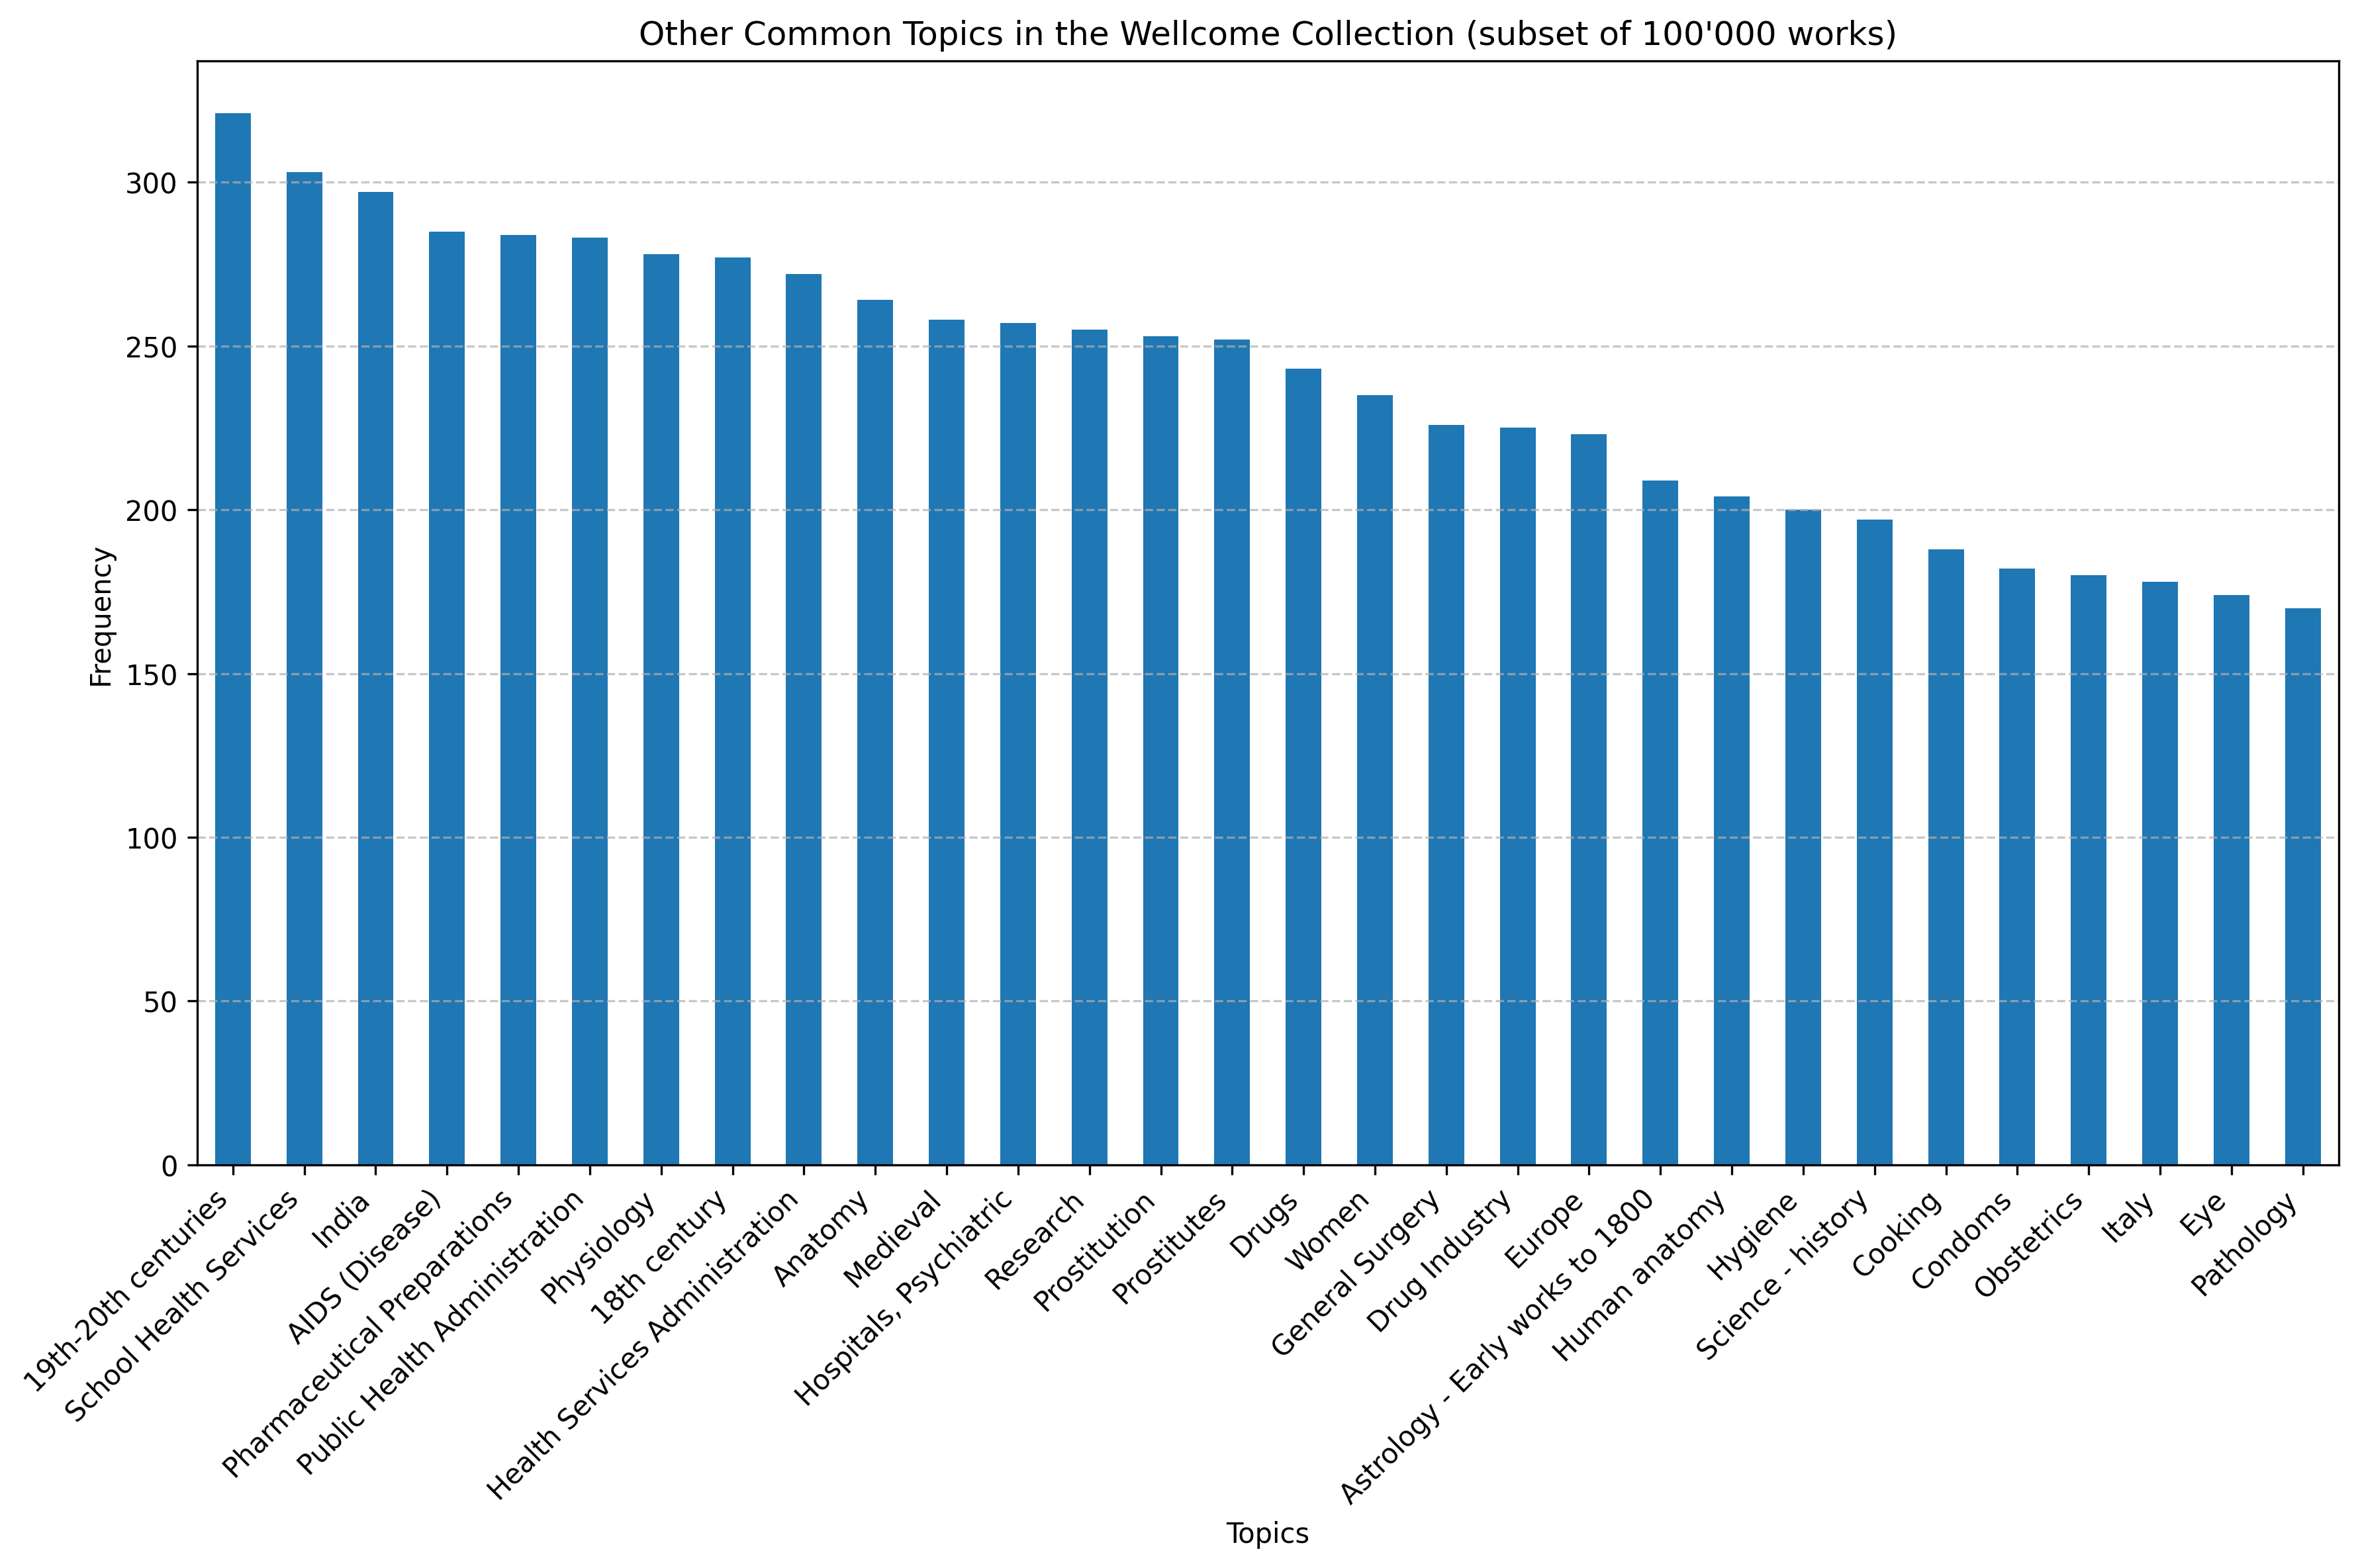

In [ ]:
# Only takig the topics that appear more than 10 times in the subset
overshadowed_topics = topics[20:50]

# Plotting
plt.figure(figsize=(12, 8))
bars = overshadowed_topics.plot(kind='bar')
plt.title("Other Common Topics in the Wellcome Collection (subset of 100'000 works)")
plt.xlabel('Topics')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


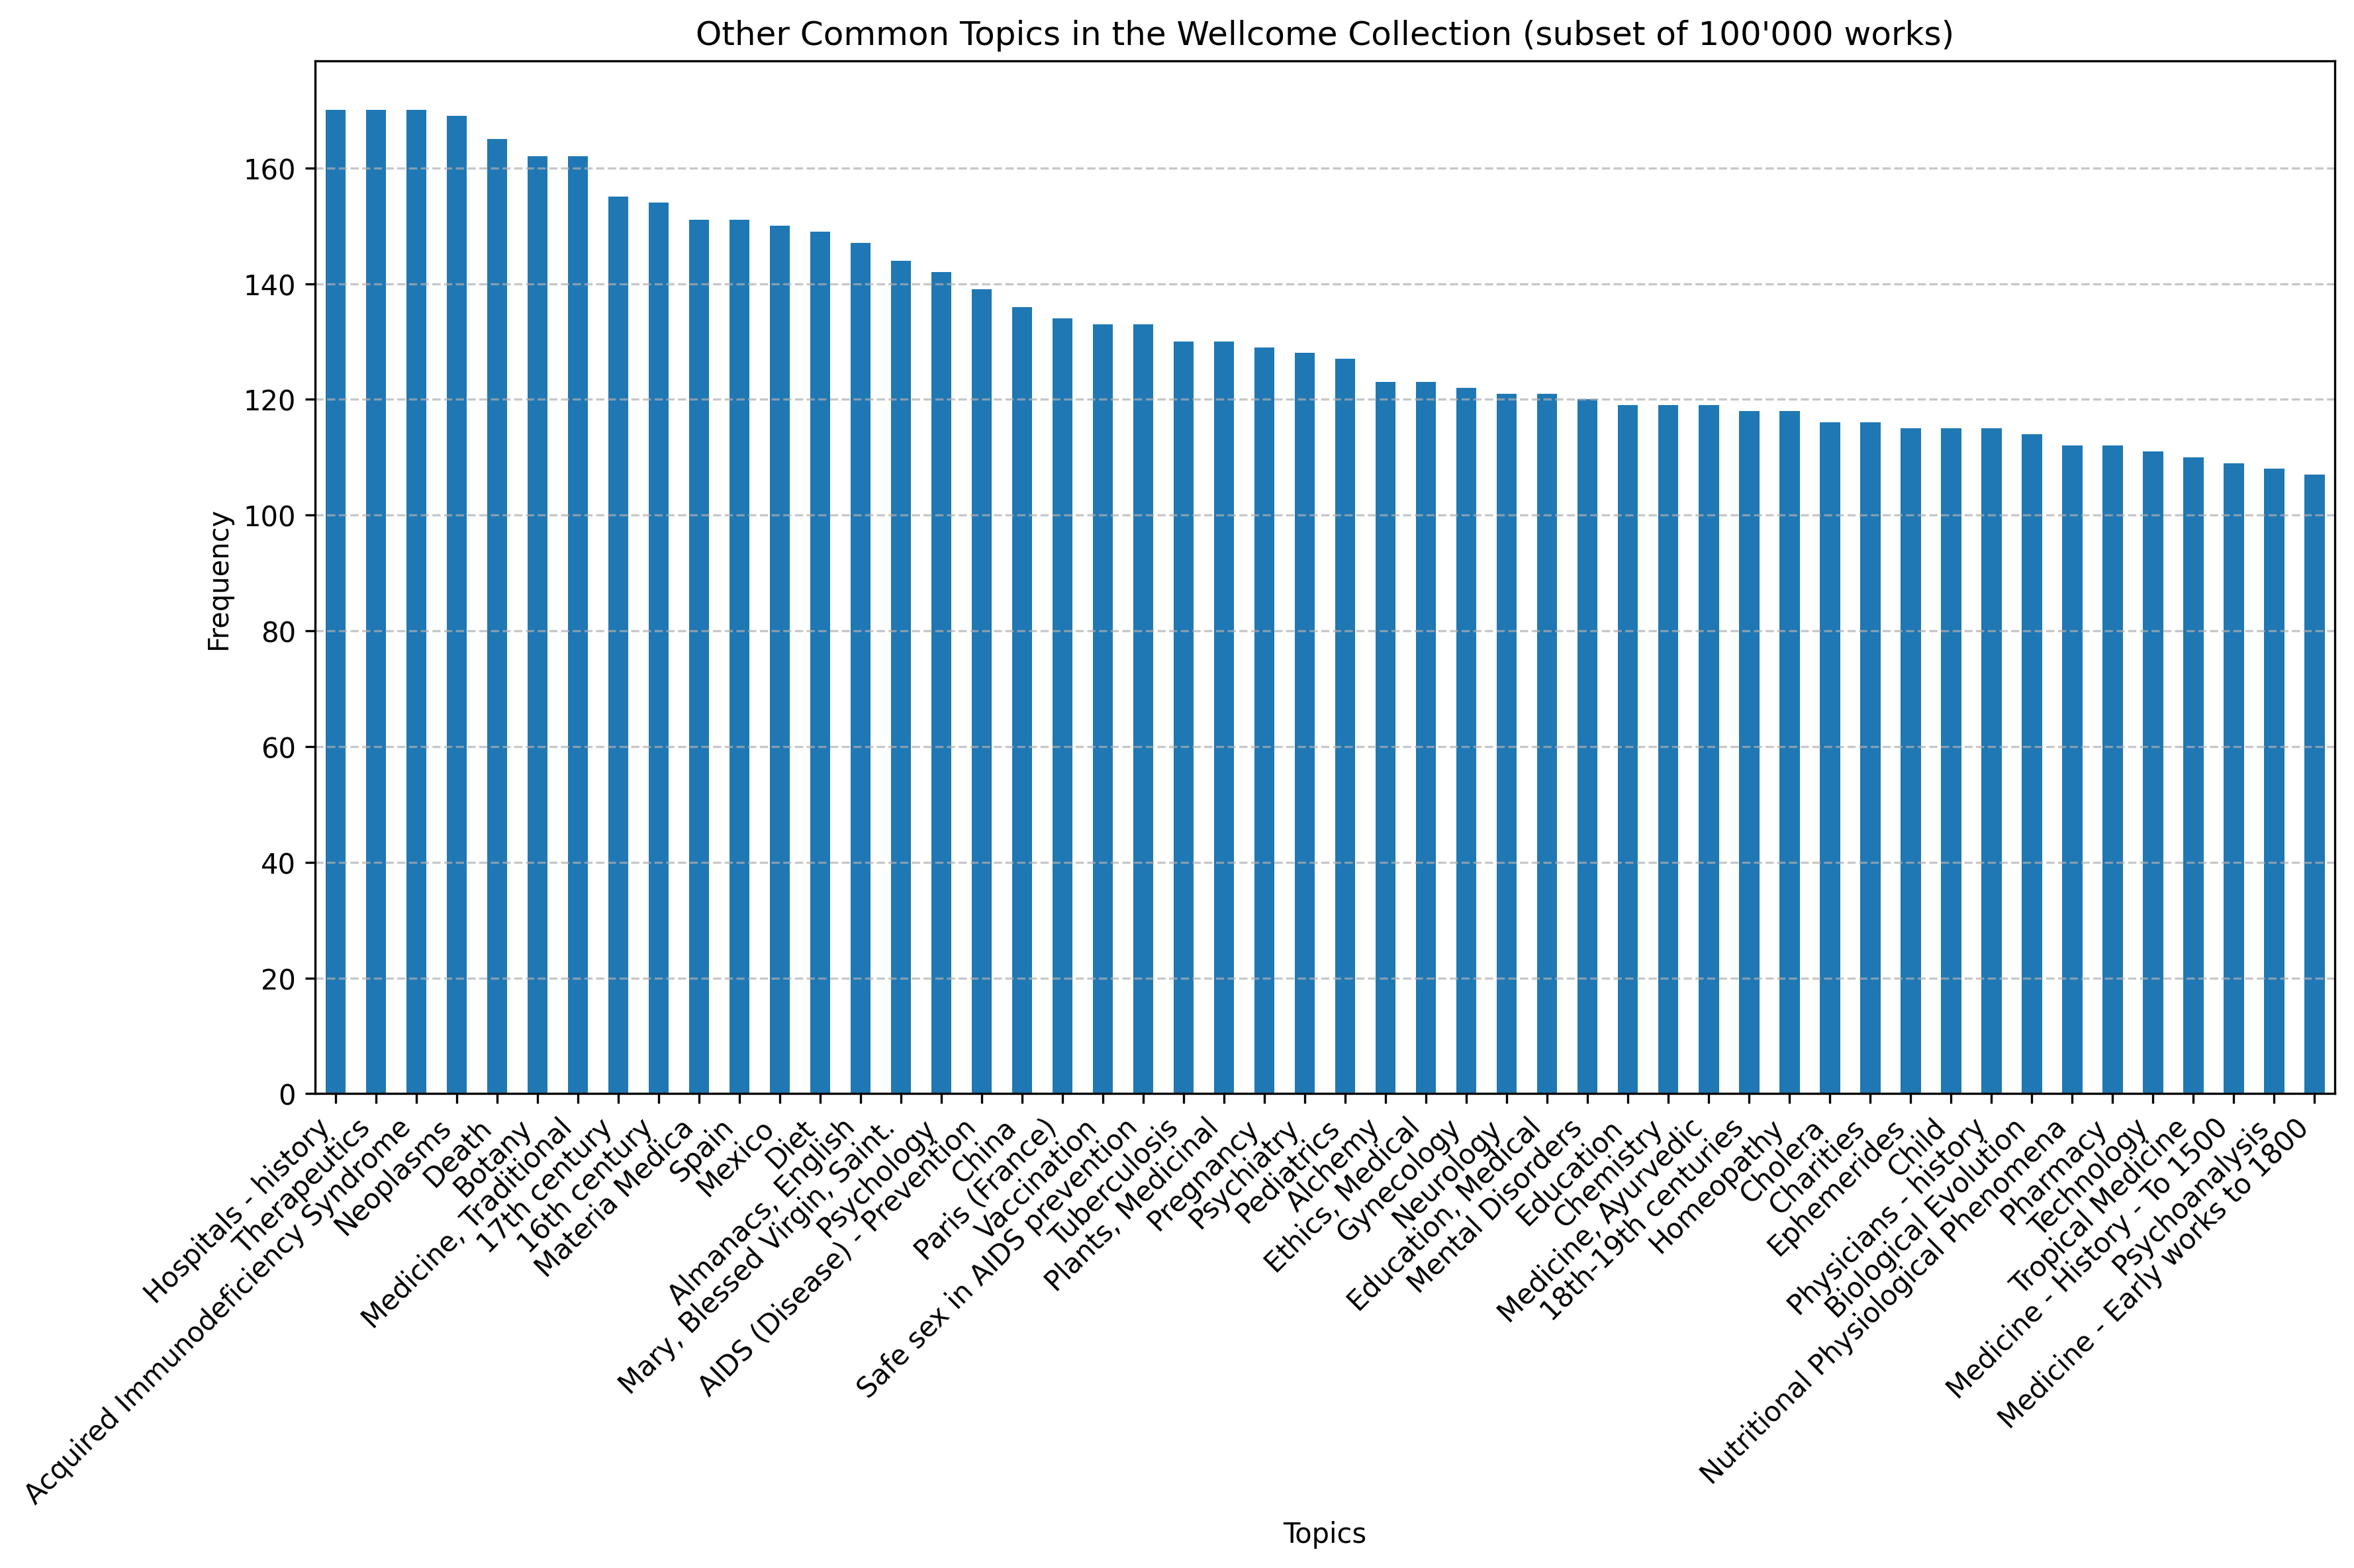

In [ ]:
# Only takig the topics that appear more than 10 times in the subset
overshadowed_topics2 = topics[50:100]

# Plotting
plt.figure(figsize=(12, 8))
bars = overshadowed_topics2.plot(kind='bar')
plt.title("Other Common Topics in the Wellcome Collection (subset of 100'000 works)")
plt.xlabel('Topics')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


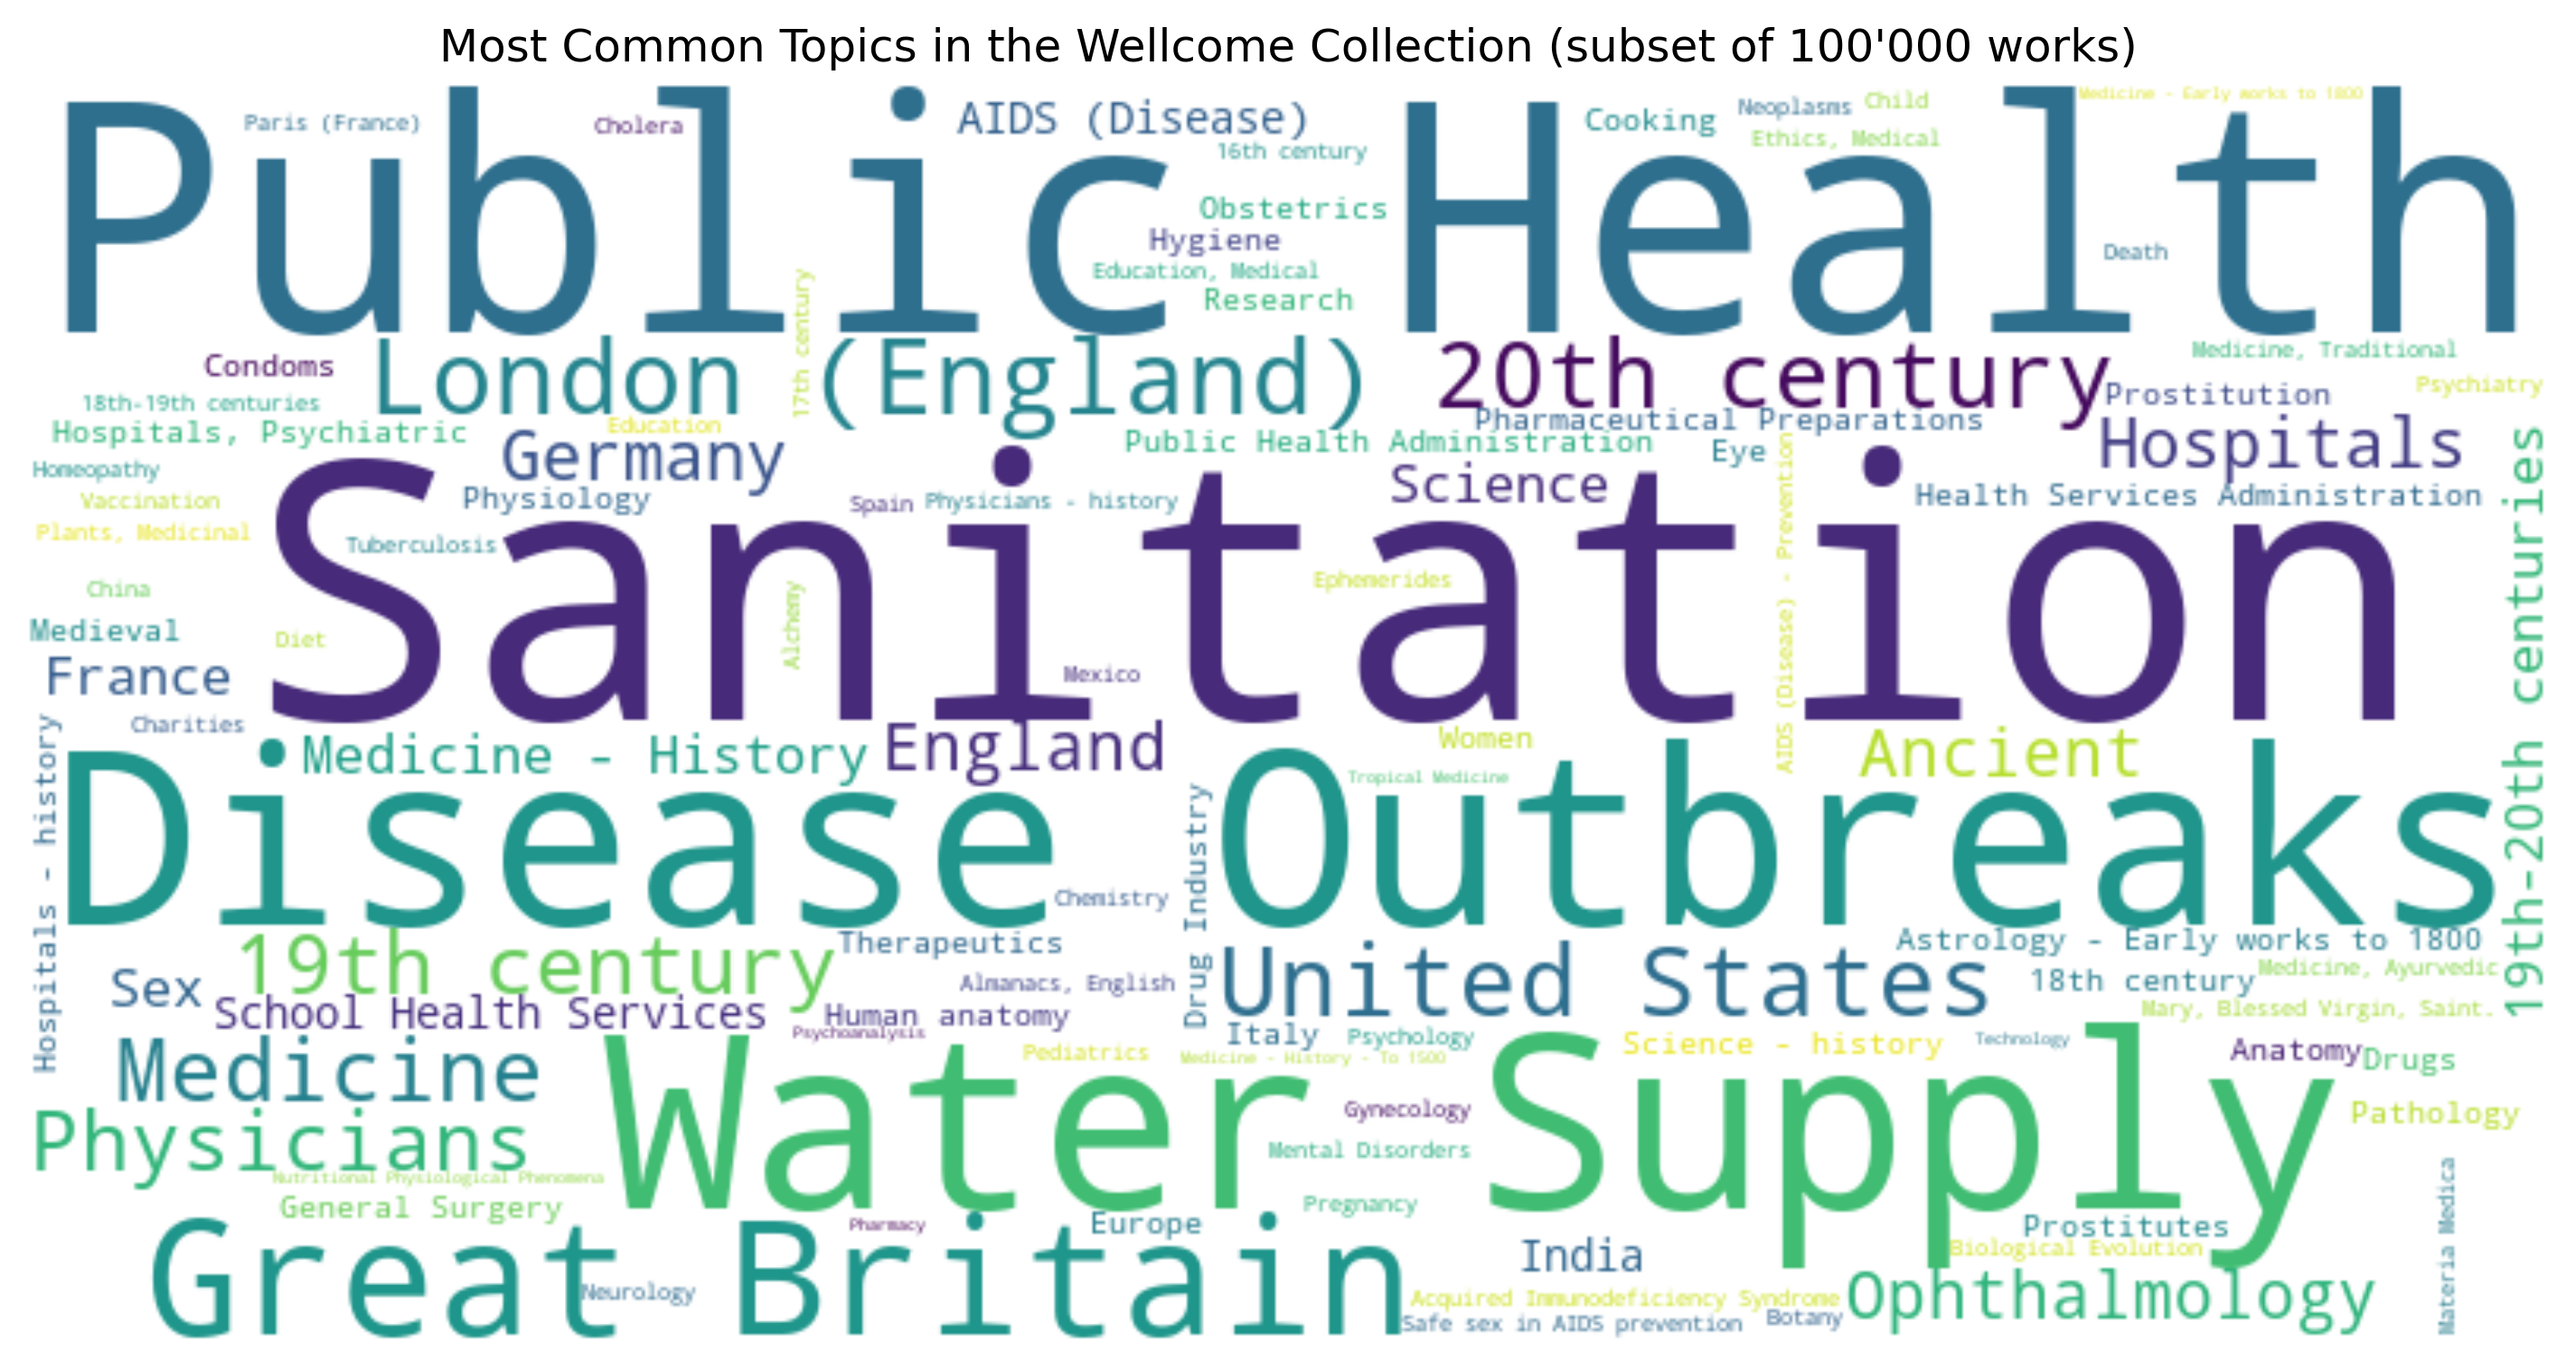

In [ ]:
# Plot a word cloud of the most common topics
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topics[:100])
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Topics in the Wellcome Collection (subset of 100'000 works)")
plt.show()

Proportion of NaN authors: 55.93%


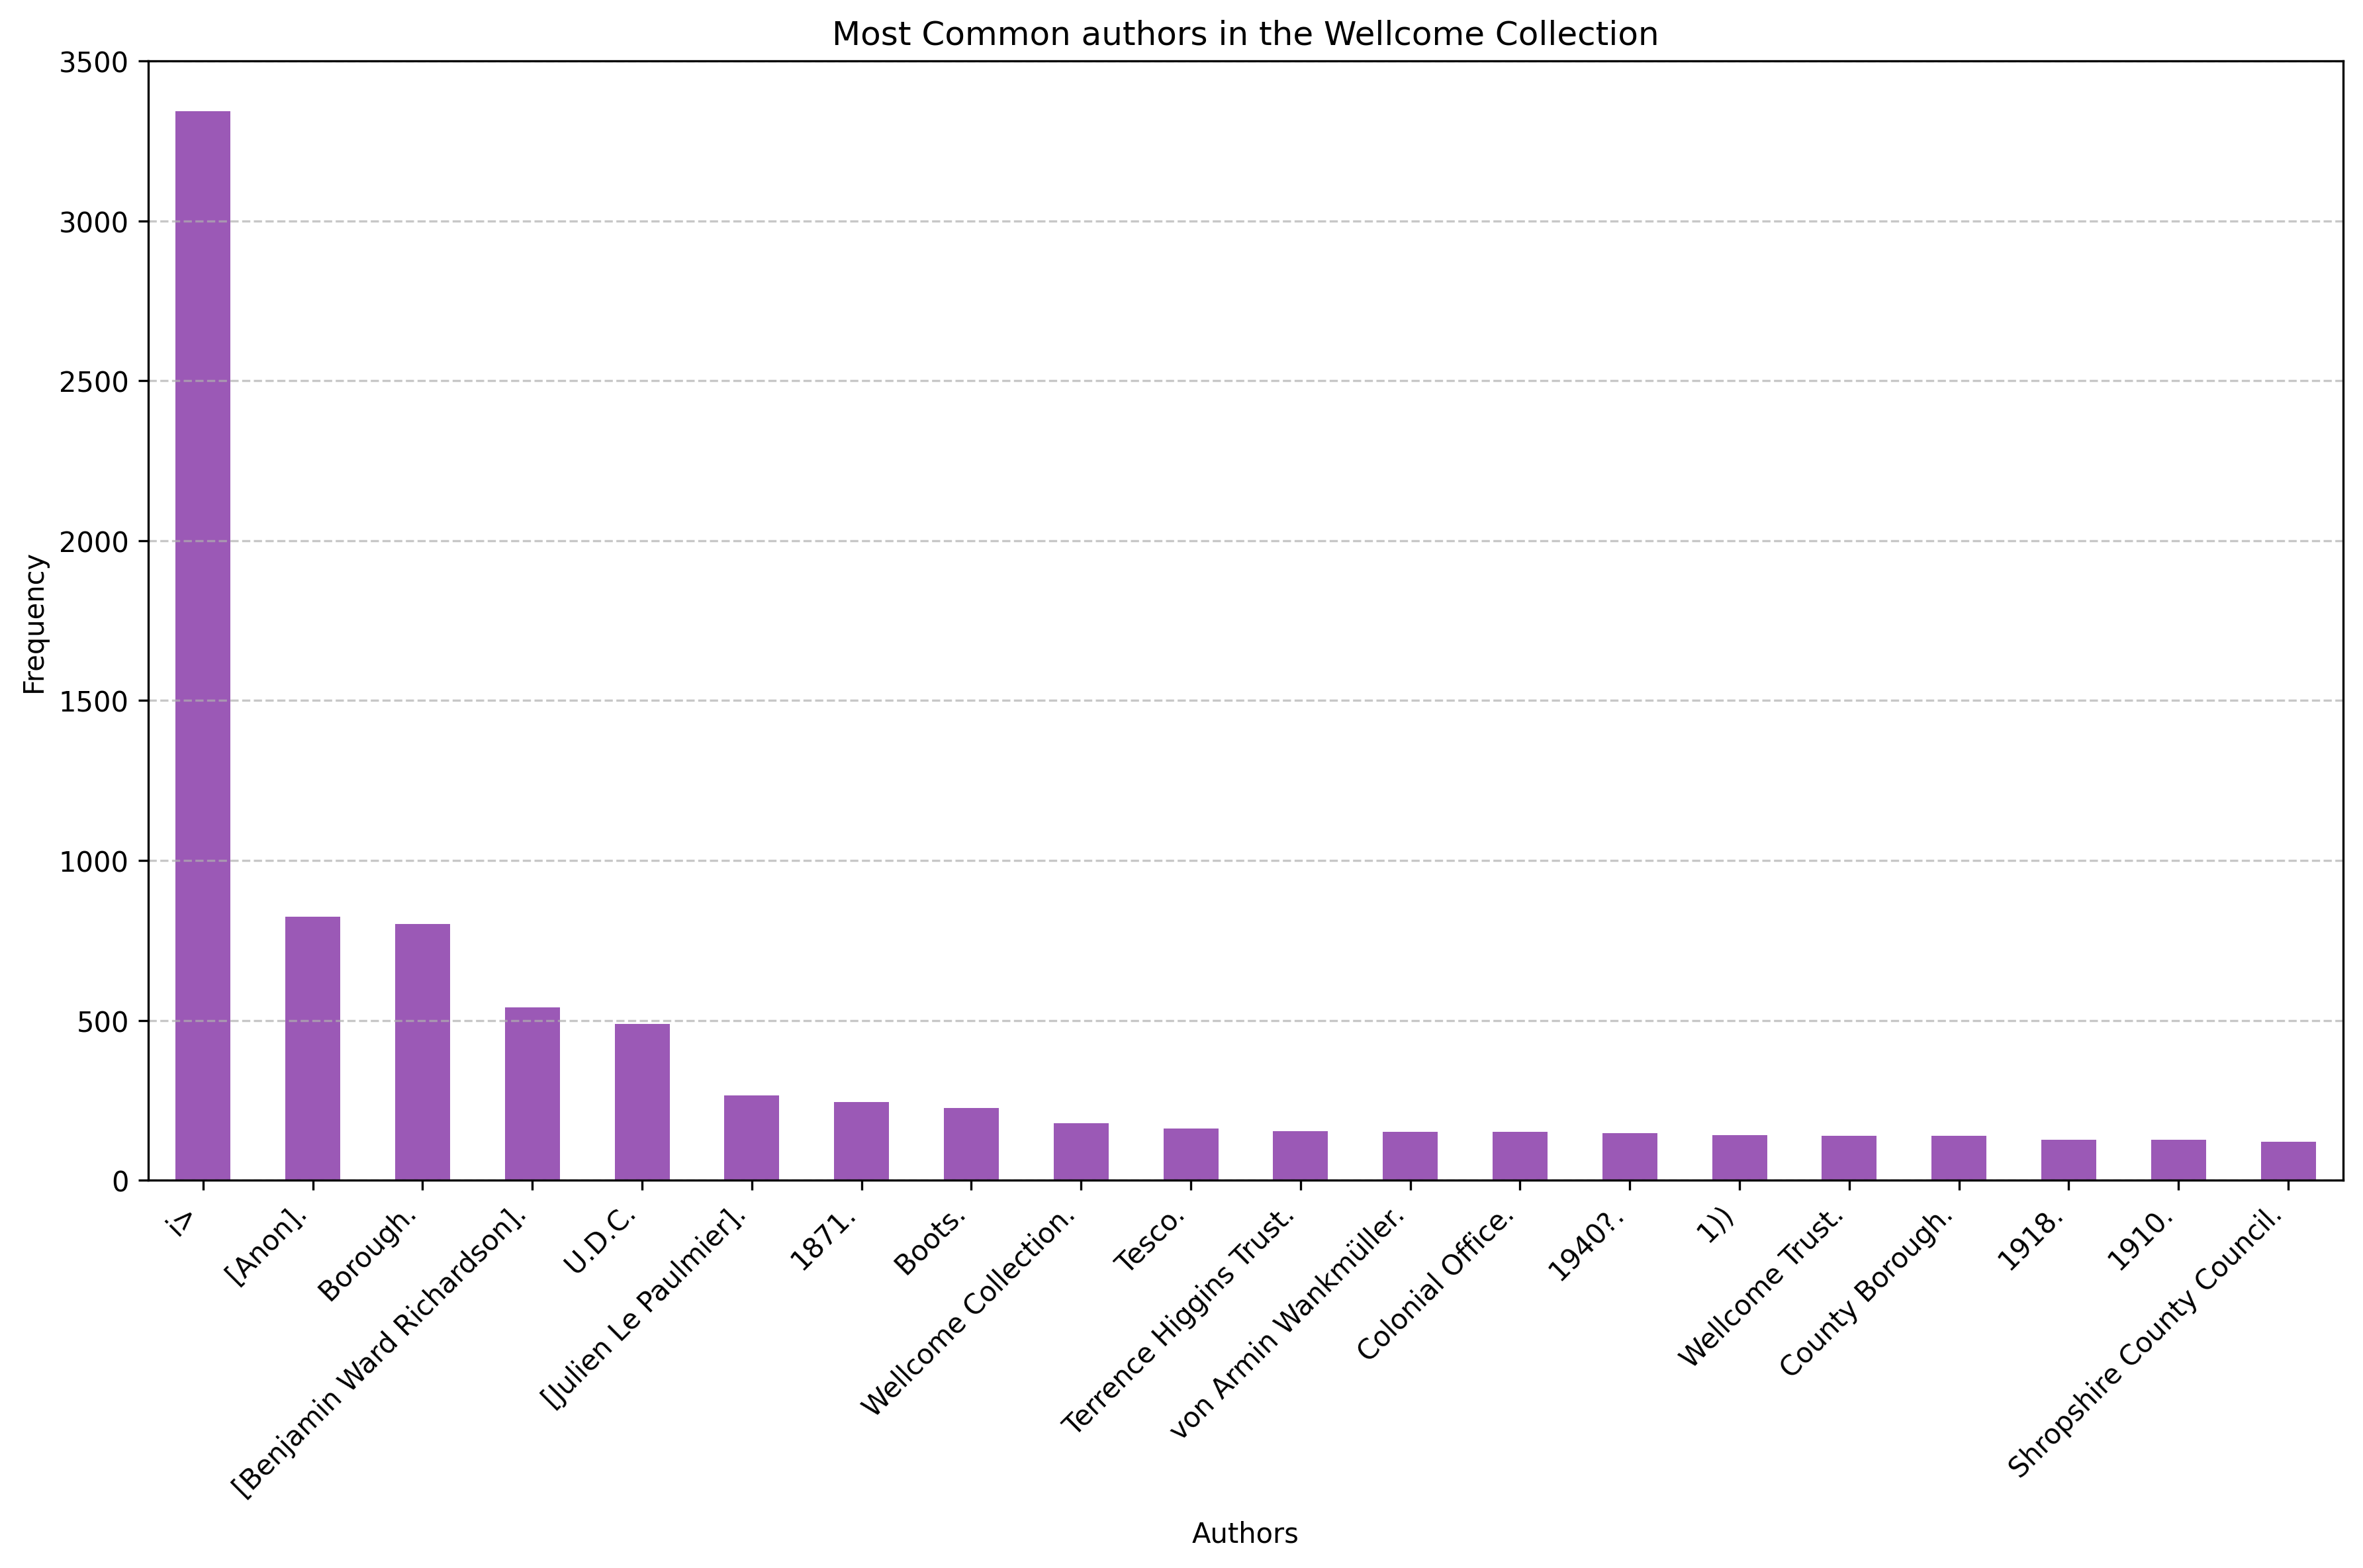

In [ ]:
authors = df['author'].dropna().value_counts()

author_nan_proportion = df['author'].isna().mean()
print(f"Proportion of NaN authors: {author_nan_proportion:.2%}")

top_authors = authors[:20]

# Plotting
plt.figure(figsize=(12, 8))
bars = top_authors.plot(kind='bar', color='#9b59b6')
plt.title("Most Common authors in the Wellcome Collection")
plt.xlabel('Authors')
plt.ylabel('Frequency')
plt.ylim(0, 3500)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Part 2: Data Analysis

Now that we have some information about the works, let's analyze some of the information about the dataset.

In [ ]:
# Begin every section by reading the most recent dataframe
df = pd.read_feather("../../data/works_abridged_df.feather")

In [ ]:
# Commented that line because takes forever to run
#df.languages.value_counts()

In [ ]:
# We need to replace "[]" in the languages with [Unknown]

df['languages'] = df['languages'].apply(lambda language_list: language_list if len(language_list) > 0 else ["Unknown"])

In [ ]:
df.languages

0          [English]
1          [English]
2            [Dutch]
3          [English]
4           [German]
             ...    
1166594    [Unknown]
1166595    [English]
1166596    [English]
1166597    [English]
1166598    [English]
Name: languages, Length: 1166599, dtype: object

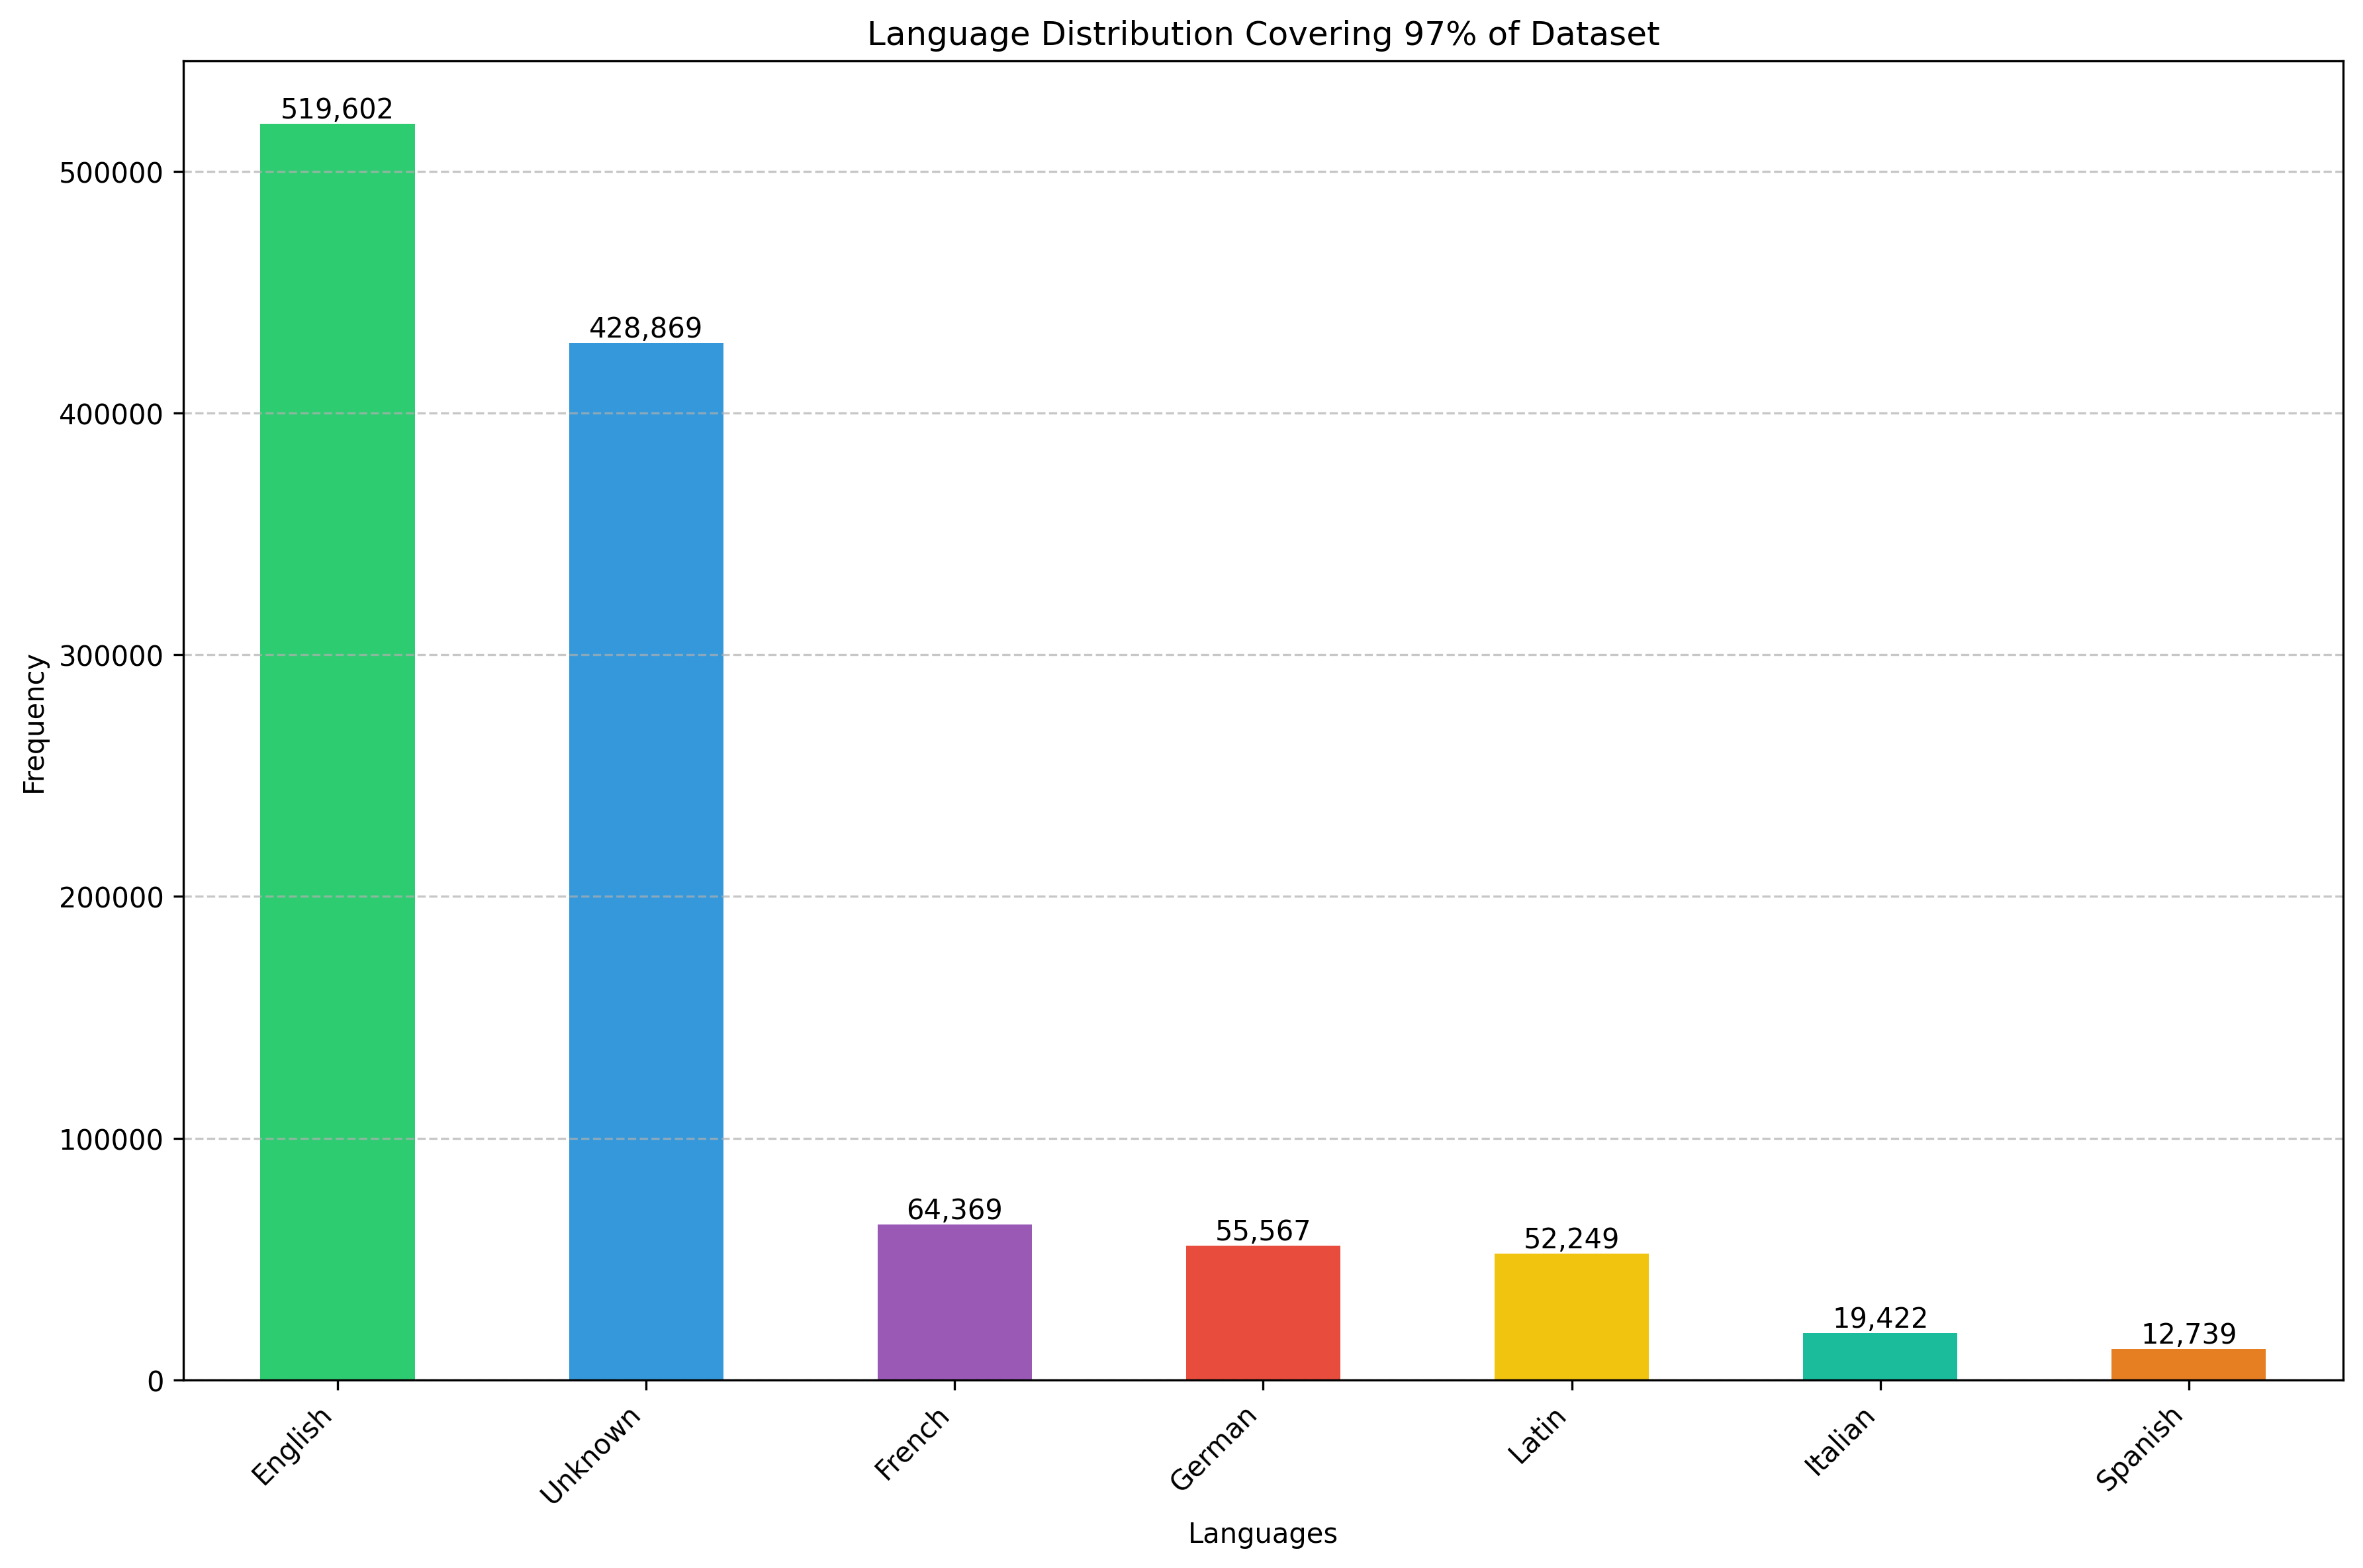

In [ ]:
df_exploded = df.explode('languages')

# Calculate the frequency of each language
language_counts = df_exploded['languages'].value_counts()

# Compute the cumulative percentage
cumulative_percentage = language_counts.cumsum() / language_counts.sum() * 100

# Filter languages that contribute to the top 95% cumulative percentage
top_95_languages = cumulative_percentage[cumulative_percentage <= 97].index
top_95_counts = language_counts.loc[top_95_languages]
# Create a color palette for the languages
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f1c40f', '#1abc9c', '#e67e22']

# Plotting
plt.figure(figsize=(12, 8))
bars = top_95_counts.plot(kind='bar', color=colors)
plt.title('Language Distribution Covering 97% of Dataset')
plt.xlabel('Languages')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, v in enumerate(top_95_counts):
    plt.text(i, v, f'{v:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Sampling From the Language Distribution

In [ ]:
import pandas as pd

# Step 1: Explode the DataFrame so each language is on its own row
df_exploded = df.explode('languages')

# Step 2: Identify the top 5 languages by frequency
language_counts = df_exploded['languages'].value_counts()
top_5_languages = language_counts.index[:5]  # e.g., ['English', 'French', 'German', 'Spanish', 'Italian']

# We'll build our final sample iteratively
df_sampled = pd.DataFrame()

# Step 3: For each language, sample up to 1,500 distinct rows that contain it
N = 1500

for lang in top_5_languages:
    # Filter rows that contain this language AND haven't been sampled yet
    subset = df[
        df['languages'].apply(lambda langs: lang in langs)
        & ~df.index.isin(df_sampled.index)
    ]
    
    # If we need exactly N, but subset is smaller, we sample all of them
    size_to_sample = min(len(subset), N)
    
    # Sample the subset
    subset_sampled = subset.sample(n=size_to_sample, random_state=42, replace=False)
    
    # Append to our growing df_sampled
    df_sampled = pd.concat([df_sampled, subset_sampled], ignore_index=False)

# Step 4: Reset the index if desired, to have a clean 0..N indexing
df_sampled.reset_index(drop=True, inplace=True)

print(f"Final df_sampled shape: {df_sampled.shape}")
print(df_sampled.head(10))

# This will contain at most 5 * 1,500 = 7,500 rows, 
# but could be fewer if there's significant overlap among languages 
# or if some languages didn't have enough rows.


Final df_sampled shape: (7500, 5)
                                               title  \
0  The hauen of health : chiefly made for the com...   
1  Funding health sciences research : a strategy ...   
2  [Report of the Medical Officer of Health for F...   
3  The right thing : ten years of ethics columns ...   
4  An inaugural essay, on the eye, and on vision ...   
5  Draft of "Selection Against Heterozygotes in Man"   
6  [Report 1943] / Medical Officer of Health, Mal...   
7  [Report 1938] / Medical Officer of Health, Cla...   
8               Letter from J B S Haldane to M Teich   
9  Current concepts in the use of doxorubicin che...   

                                            subjects  languages  \
0                     [Health - Early works to 1800]  [English]   
1  [Health Policy, Research Support as Topic - or...  [English]   
2                       [Finsbury (London, England)]  [English]   
3                                  [Ethics, Medical]  [English]   
4             

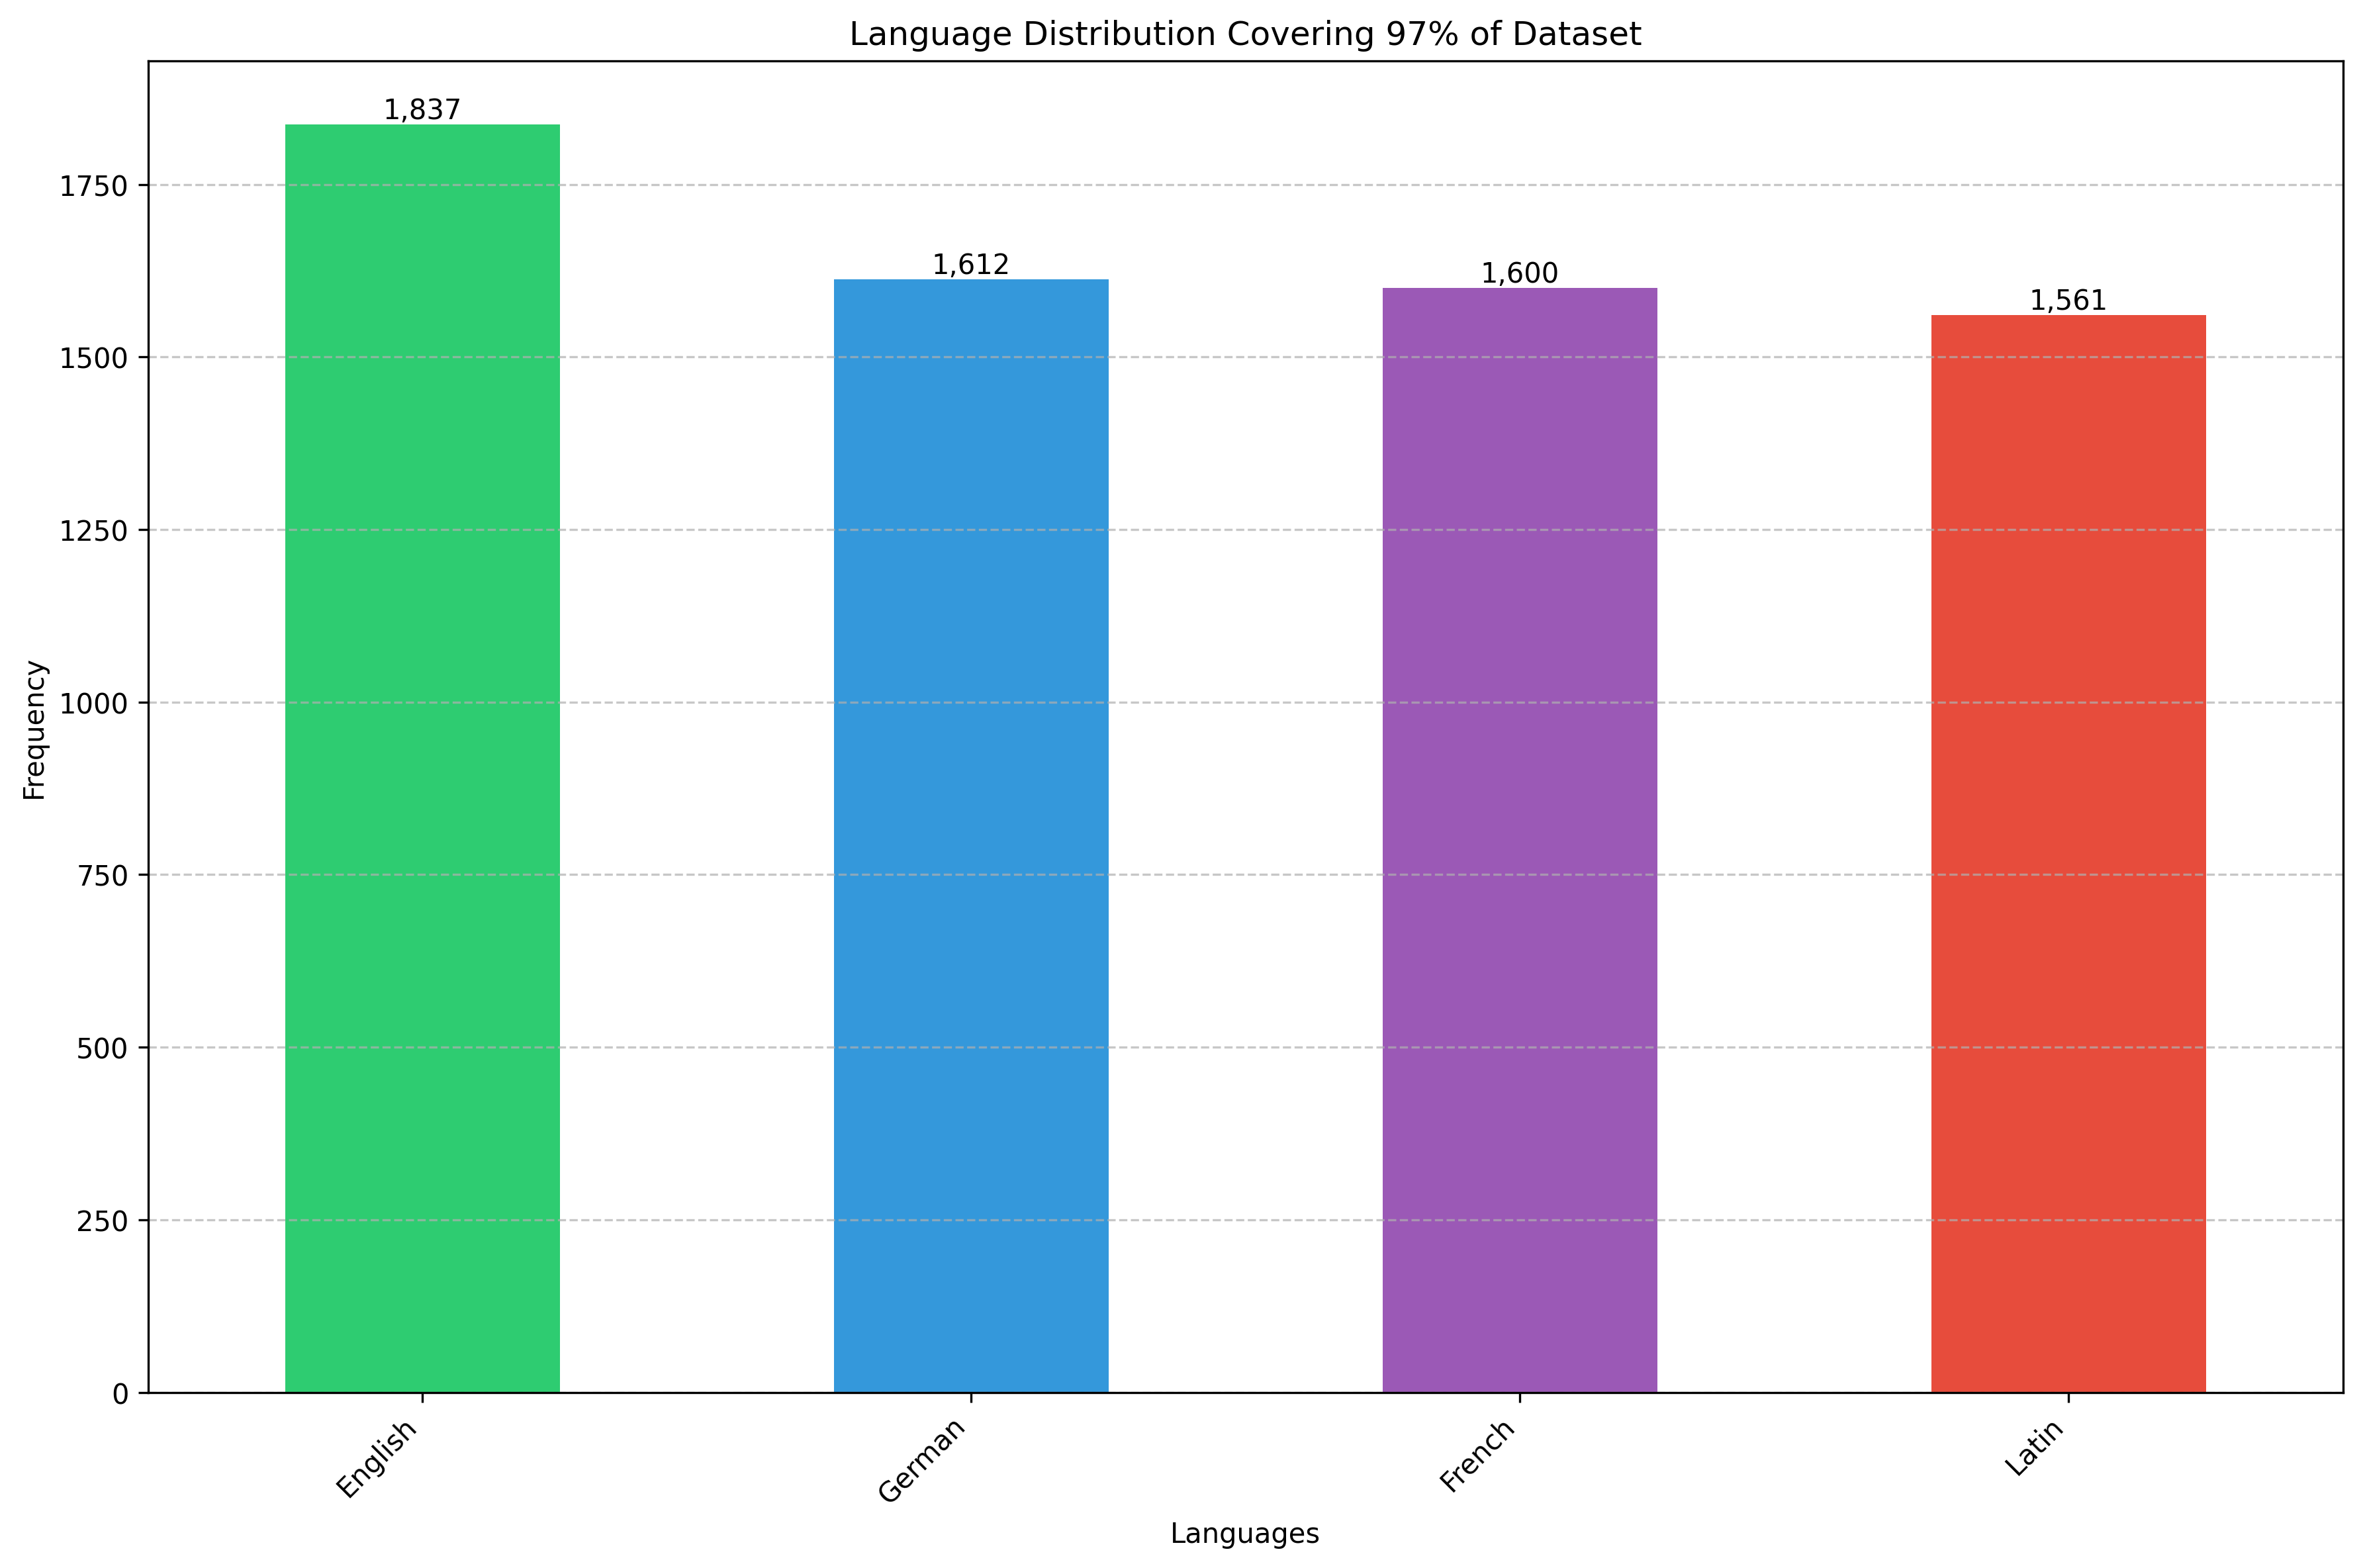

In [ ]:
df_exploded = df_sampled.explode('languages')

# Calculate the frequency of each language
language_counts = df_exploded['languages'].value_counts()

# Compute the cumulative percentage
cumulative_percentage = language_counts.cumsum() / language_counts.sum() * 100

# Filter languages that contribute to the top 95% cumulative percentage
top_95_languages = cumulative_percentage[cumulative_percentage <= 97].index
top_95_counts = language_counts.loc[top_95_languages]
# Create a color palette for the languages
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f1c40f', '#1abc9c', '#e67e22']

# Plotting
plt.figure(figsize=(12, 8))
bars = top_95_counts.plot(kind='bar', color=colors)
plt.title('Language Distribution Covering 97% of Dataset')
plt.xlabel('Languages')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, v in enumerate(top_95_counts):
    plt.text(i, v, f'{v:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Monolingual vs. Multilingual Embeddings on Titles

Let's look at the difference between mono and multilingual embeddings.

In [ ]:
import os
os.environ["HUGGINGFACE_API_KEY"] = 'your_token_here'
monolingual_model_id = "sentence-transformers/all-MiniLM-L6-v2"
multilingual_model_id = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
model_id = "sentence-transformers/distiluse-base-multilingual-cased-v2"
hf_token = os.getenv("HUGGINGFACE_API_KEY")
if hf_token is None:
    raise EnvironmentError("Missing required environment variable: HUGGINGFACE_API_KEY")

In [ ]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
embeddings = model.encode(sentences)
print(embeddings)


In [ ]:
df_sampled

,title,subjects,languages,author,title_only
0,The hauen of health : chiefly made for the com...,[Health - Early works to 1800],[English],None,The hauen of health : chiefly made for the com...
1,Funding health sciences research : a strategy ...,"[Health Policy, Research Support as Topic - or...",[English],Committee on Policies for Allocating Health S...,Funding health sciences research : a strategy ...
2,[Report of the Medical Officer of Health for F...,"[Finsbury (London, England)]",[English],None,[Report of the Medical Officer of Health for F...
3,The right thing : ten years of ethics columns ...,"[Ethics, Medical]",[English],Emily Friedman ; foreword by Kathryn E. Johnson.,The right thing : ten years of ethics columns ...
4,"An inaugural essay, on the eye, and on vision ...","[Eye, Vision, Ocular]",[English],"by Elisha de Butts, of Maryland.","An inaugural essay, on the eye, and on vision ..."
...,...,...,...,...,...
7495,"Dissertatio medica inauguralis, de hydrothorac...",[Hydrothorax],[Latin],Eruditorum examini subjicit Edvardus Kelly.,"Dissertatio medica inauguralis, de hydrothorac..."
7496,Disputationes philosophicae de rerum naturaliu...,[],[Latin],[Burcherus de Volder].,Disputationes philosophicae de rerum naturaliu...
7497,The Christ Child as a professor sitting at a d...,[Heart],[Latin],None,The Christ Child as a professor sitting at a d...
7498,Lectori benevolo S.P.D. ipsique diros calculor...,[],[Latin],[Johann Andreas Fischer].,Lectori benevolo S.P.D. ipsique diros calculor...


In [ ]:
monolingual_api_url = f"https://api-inference.huggingface.co/pipeline/feature-extraction/{monolingual_model_id}"
multilingual_api_url = f"https://api-inference.huggingface.co/pipeline/feature-extraction/{multilingual_model_id}"
headers = {"Authorization": f"Bearer {hf_token}"}

api_url = f"https://api-inference.huggingface.co/pipeline/feature-extraction/{model_id}"


In [ ]:
monolingual_api_url

'https://api-inference.huggingface.co/pipeline/feature-extraction/sentence-transformers/all-MiniLM-L6-v2'

In [ ]:
def query(texts, this_api_url):
    response = requests.post(this_api_url, headers=headers, json={"inputs": texts, "options":{"wait_for_model":True}})
    return response.json()

In [ ]:
texts = df_sampled['title_only'].to_list()

In [ ]:
# monolingual encodings
monolingual_embeddings = query(texts, monolingual_api_url)
df_sampled['monolingual_embeddings'] = monolingual_embeddings

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
multilingual_embeddings = query(texts, multilingual_api_url)
df_sampled['multilingual_embeddings'] = multilingual_embeddings

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
import pandas as pd
import csv
import ast

# Example DataFrame (df) columns:
# ["title", "subjects", "languages", "author", "title_only",
#  "weight", "monolingual_encodings", "multilingual_encodings"]

# 1) Function to convert embedding to a Python list (if needed)
def ensure_list(embedding):
    if isinstance(embedding, str):
        # Convert string like "[0.123, 0.456, ...]" to a list of floats
        return ast.literal_eval(embedding)
    return embedding

# 2) Open two output file pairs: monolingual + multilingual
with open("../../data/embeddings/monolingual_vectors.tsv", "w", newline="", encoding="utf-8") as mono_vec_f, \
     open("../../data/embeddings/monolingual_metadata.tsv", "w", newline="", encoding="utf-8") as mono_meta_f, \
     open("../../data/embeddings/multilingual_vectors.tsv", "w", newline="", encoding="utf-8") as multi_vec_f, \
     open("../../data/embeddings/multilingual_metadata.tsv", "w", newline="", encoding="utf-8") as multi_meta_f:
    
    # Create CSV writers with tab delimiter
    mono_vec_writer = csv.writer(mono_vec_f, delimiter="\t")
    mono_meta_writer = csv.writer(mono_meta_f, delimiter="\t")
    multi_vec_writer = csv.writer(multi_vec_f, delimiter="\t")
    multi_meta_writer = csv.writer(multi_meta_f, delimiter="\t")
    
    # Optional: write header rows in the metadata files (TF Embedding Projector supports it)
    # Each row in metadata = [title, language]
    # mono_meta_writer.writerow(["title", "language"])
    # multi_meta_writer.writerow(["title", "language"])
    
    # 3) Iterate over every row in df and write to both monolingual & multilingual
    for _, row in df_sampled.iterrows():
        
        # --------- MONOLINGUAL EMBEDDING ---------
        mono_emb_list = ensure_list(row["monolingual_embeddings"])
        if mono_emb_list:
            mono_vec_writer.writerow(mono_emb_list)
            # Metadata: use the row's title and languages
            # If row["languages"] is a list, join them
            if isinstance(row["languages"], list):
                lang_str = ", ".join(row["languages"])
            else:
                lang_str = str(row["languages"])
            mono_meta_writer.writerow([row["title"], lang_str])
        
        # --------- MULTILINGUAL EMBEDDING --------
        multi_emb_list = ensure_list(row["multilingual_embeddings"])
        if multi_emb_list:
            multi_vec_writer.writerow(multi_emb_list)
            # Same metadata approach
            if isinstance(row["languages"], list):
                lang_str = ", ".join(row["languages"])
            else:
                lang_str = str(row["languages"])
            multi_meta_writer.writerow([row["title"], lang_str])

print("TSV files created:")
print(" - monolingual_vectors.tsv / monolingual_metadata.tsv")
print(" - multilingual_vectors.tsv / multilingual_metadata.tsv")


KeyError: 'monolingual_embeddings'

In [ ]:
df_sampled.languages.iloc[0][0]

In [ ]:
type(df_sampled.languages.iloc[0])

In [ ]:
import csv
import ast
import numpy as np

def parse_embedding(embedding):
    """
    Convert a string like '[0.123, 0.456]' to a Python list if needed.
    Otherwise, if 'embedding' is already a list of floats, just return it.
    """
    if isinstance(embedding, str):
        return ast.literal_eval(embedding)
    return embedding

def get_first_language(languages_value):
    """
    If 'languages_value' is a string that looks like a list (e.g. "['Latin', 'French']"),
    parse it via ast.literal_eval. Then, if it's a list, return the first item. 
    Otherwise, return the value as-is, cast to a string.
    """


    # If now it's a list with at least one element, pick the first item
    if isinstance(languages_value, list) or isinstance(languages_value, np.ndarray) and len(languages_value) > 0:
        return str(languages_value[0])
    else:
        
        return str(languages_value)


def write_embeddings_and_metadata(df, embedding_col, vectors_file, metadata_file):
    """
    For each row in df:
      1) Read the embedding_col (either monolingual_encodings or multilingual_encodings).
      2) If it has a valid list of floats, write one line to vectors_file
         and one line (title + joined languages) to metadata_file.

    This version ensures that any newline characters in the 'title' or 'languages'
    columns are replaced with spaces before writing.
    """
    with open(vectors_file, "w", encoding="utf-8", newline="") as vf, \
         open(metadata_file, "w", encoding="utf-8", newline="") as mf:
        
        vector_writer = csv.writer(vf, delimiter="\t")
        meta_writer = csv.writer(mf, delimiter="\t")

        meta_writer.writerow(["title", "languages"])
        
        count_lines = 0
        for _, row in df.iterrows():
            emb = parse_embedding(row[embedding_col])
            if emb and len(emb) > 0:   # Only write if the embedding is non-empty
                # 1) Write embeddings
                vector_writer.writerow(emb)
                
                
                langs_str = get_first_language(row["languages"])

                # print(lang_str)
                
                # 3) Clean title and langs to remove any newline chars
                title_str = str(row["title"]).replace("\n", " ").replace("\r", " ")
                langs_str = langs_str.replace("\n", " ").replace("\r", " ")
                
                # 4) Write to metadata
                meta_writer.writerow([title_str, langs_str])
                count_lines += 1
        
        print(f"Finished writing {count_lines} lines to {vectors_file} and {metadata_file}.")

# -------------------------------------------------------------------
# Usage:
# -------------------------------------------------------------------
# Convert NaN to empty string first (optional, if some rows are missing the column)
df_sampled["title_only"] = df_sampled["title_only"].fillna("")

# Replace any newline or carriage return with a single space
df_sampled["title_only"] = (
    df_sampled["title_only"]
    .astype(str)
    .str.replace(r"[\r\n]+", " ", regex=True)
)

write_embeddings_and_metadata(
    df_sampled,
    embedding_col="monolingual_embeddings",
    vectors_file="../../data/embeddings/monolingual_vectors.tsv",
    metadata_file="../../data/embeddings/monolingual_metadata.tsv"
)

write_embeddings_and_metadata(
    df_sampled,
    embedding_col="multilingual_embeddings",
    vectors_file="../../data/embeddings/multilingual_vectors.tsv",
    metadata_file="../../data/embeddings/multilingual_metadata.tsv"
)


In [ ]:
with open("../../data/embeddings/monolingual_vectors.tsv", "r", encoding="utf-8") as f:
    monolingual_vec_lines = sum(1 for _ in f)
with open("../../data/embeddings/monolingual_metadata.tsv", "r", encoding="utf-8") as f:
    monolingual_meta_lines = sum(1 for _ in f)
print("Monolingual: vectors =", monolingual_vec_lines, "metadata =", monolingual_meta_lines)

with open("../../data/embeddings/multilingual_vectors.tsv", "r", encoding="utf-8") as f:
    multilingual_vec_lines = sum(1 for _ in f)
with open("../../data/embeddings/multilingual_metadata.tsv", "r", encoding="utf-8") as f:
    multilingual_meta_lines = sum(1 for _ in f)
print("Multilingual: vectors =", multilingual_vec_lines, "metadata =", multilingual_meta_lines)


In [ ]:
df_sampled.to_feather("../../data/sampled_language_df.feather")

### Topic Analysis on The Subjects

In [ ]:
import spacy
from bertopic import BERTopic

In [ ]:
docs = df.subjects.explode().dropna().to_list()

In [ ]:
len(docs)

In [ ]:
import random
# docs_subset = random.sample(docs, 50000)
docs_subset = random.sample(docs, 10000)

In [ ]:
nlp = spacy.load("en_core_web_lg", exclude=['tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer'])
topic_model = BERTopic(embedding_model=nlp.pipe, nr_topics=25)
topics, probs = topic_model.fit_transform(docs_subset)

In [ ]:
# topic_model = BERTopic.load("../../models/bertopic_subset_03_26.safetensors")

In [ ]:
from scipy.cluster import hierarchy as sch


linkage_function = lambda x: sch.linkage(x, 'single', optimal_ordering=True)
hierarchical_topics = topic_model.hierarchical_topics(docs_subset, linkage_function=linkage_function)

In [ ]:
hierarchical_topics

In [ ]:
import networkx as nx
import pandas as pd
import networkx as nx

# Assuming `hierarchical_topics` is your DataFrame
def build_networkx_tree(hierarchical_topics: pd.DataFrame) -> nx.DiGraph:
    """
    Converts hierarchical_topics DataFrame into a NetworkX directed graph (tree).

    Parameters
    ----------
    hierarchical_topics : pd.DataFrame
        DataFrame containing hierarchical topic data with columns:
        ['Parent_ID', 'Parent_Name', 'Child_Left_ID', 'Child_Left_Name',
         'Child_Right_ID', 'Child_Right_Name', 'Distance']

    Returns
    -------
    nx.DiGraph
        Directed graph representing the hierarchical tree.
    """
    tree = nx.DiGraph()

    for _, row in hierarchical_topics.iterrows():
        parent_id = row['Parent_ID']
        parent_name = row['Parent_Name']

        child_left_id = row['Child_Left_ID']
        child_left_name = row['Child_Left_Name']

        child_right_id = row['Child_Right_ID']
        child_right_name = row['Child_Right_Name']

        distance = row['Distance']

        # Add nodes with attributes
        tree.add_node(parent_id, name=parent_name)
        tree.add_node(child_left_id, name=child_left_name)
        tree.add_node(child_right_id, name=child_right_name)

        # Add edges with distance attribute
        tree.add_edge(parent_id, child_left_id, distance=distance)
        tree.add_edge(parent_id, child_right_id, distance=distance)

    return tree

# Example usage:
tree = build_networkx_tree(hierarchical_topics)
nx.draw(tree, with_labels=False, labels=nx.get_node_attributes(tree, 'name'))

In [ ]:
import plotly.io as pio
pio.renderers.default = 'jupyterlab'


In [ ]:
fig = topic_model.visualize_topics()
fig.show()